In [12]:
import io
import os
import cv2
import keras
import easyocr
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
reader = easyocr.Reader(['en'],gpu=False)

from PIL import Image
from ipywidgets import FileUpload
from IPython.display import display
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer

Using CPU. Note: This module is much faster with a GPU.


In [13]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
characters = sorted(['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
max_len = 21
AUTOTUNE = tf.data.AUTOTUNE
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [14]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]
    
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image, paddings=[ [pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0],],)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [15]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [16]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:max_len]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [17]:
def segmentation(uploader):
    img = None
    for name, file_info in uploader.value.items():
        img = io.BytesIO(file_info['content'])
        img = cv2.imdecode(np.frombuffer(img.read(), np.uint8), 1)
    result = reader.readtext(img)
    
    for count,detection in enumerate(result): 
        top_left = tuple(detection[0][0])
        bottom_right = tuple(detection[0][2])
        try:
            temp = img[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
            cv2.imwrite("Segmented/{}{}.png".format("0",str(count).zfill(3)), temp)
            count += 1
        except TypeError:
            pass
    plt.imshow(img)

In [40]:
uploader = FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

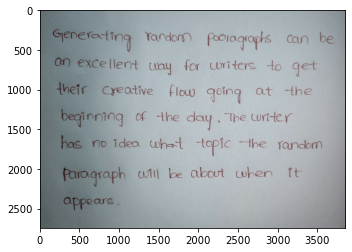

In [41]:
segmentation(uploader)

In [31]:
# os.chdir('segmented')
images_paths = os.listdir('segmented')
images_paths = [os.path.join('segmented',i) for i in images_paths]
print(images_paths)
labels = [' '] * len(images_paths)

['segmented\\0000.png', 'segmented\\0001.png', 'segmented\\0002.png', 'segmented\\0003.png', 'segmented\\0004.png', 'segmented\\0005.png', 'segmented\\0006.png', 'segmented\\0007.png', 'segmented\\0008.png', 'segmented\\0009.png', 'segmented\\0010.png', 'segmented\\0011.png', 'segmented\\0012.png', 'segmented\\0013.png', 'segmented\\0014.png', 'segmented\\0015.png', 'segmented\\0016.png', 'segmented\\0017.png', 'segmented\\0018.png', 'segmented\\0019.png', 'segmented\\0020.png', 'segmented\\0021.png', 'segmented\\0022.png', 'segmented\\0023.png', 'segmented\\0024.png', 'segmented\\0025.png', 'segmented\\0026.png', 'segmented\\0027.png', 'segmented\\0028.png', 'segmented\\0029.png', 'segmented\\0030.png', 'segmented\\0031.png', 'segmented\\0032.png', 'segmented\\0033.png', 'segmented\\0034.png', 'segmented\\0035.png', 'segmented\\0036.png']


In [32]:
test=prepare_dataset(images_paths,labels)

In [33]:
temp = [x['image'] for x in test]

In [34]:
mymodel = tf.keras.models.load_model('handwritten_org_50_epoch.h5',compile=False)

In [35]:
from spellchecker import SpellChecker

In [36]:
preds = mymodel.predict(temp)
pred_texts = decode_batch_predictions(preds)
spell = SpellChecker()
output = []
for word in pred_texts:
    Corr_Word = spell.correction(word)
    if type(Corr_Word) != type(None):
        output.append(Corr_Word)
    else:
        output.append(word)

2/2 [==============================] - 2s 36ms/step


In [37]:
output = " ".join(map(str,output)).lower().title()
print(output)

# Analysts Model Crested Object Oriented These . Is Transformed Lybect Testes Learn Sato A Moved Thet Sons Ae Per 8 Forthose Creation Oonesutta Ere Sepprongered Different Levels Pudelesrety We To Aggeregtee Component Ae Porttonet Sat Stone
